In [84]:
import numpy as np
import taichi as ti
import matplotlib.pyplot as plt
import scipy

ti.init(arch=ti.gpu)

[Taichi] Starting on arch=cuda


In [85]:
def erf(x):
    # save the sign of x
    sign = 1 if x >= 0 else -1
    x = abs(x)

    # constants
    a1 = 0.254829592
    a2 = -0.284496736
    a3 = 1.421413741
    a4 = -1.453152027
    a5 = 1.061405429
    p = 0.3275911

    # A&S formula 7.1.26
    t = 1.0 / (1.0 + p * x)
    y = 1.0 - (((((a5 * t + a4) * t) + a3) * t + a2) * t + a1) * t * ti.exp(-x * x)
    return sign * y


def erfc(x):
    return 1 - erf(x)

In [86]:
def mgkfs_recursive_moments(T0, T1, u, mfp):
    m = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
    m[0] = T0
    m[1] = T1
    for k in range(5):
        m[k + 2] = m[k + 1] * u + m[k] * (k + 1) / (2 * mfp)
    return m

In [87]:
D = 2
K = 1
b = K + D

PI = 3.1415926535897
EPS = 1e-3
CFL = 0.4

c_s = 1
T_ref = 1.0
gamma = (b + 2) / b
Rg = c_s**2 / (gamma * T_ref)

tau = 0.123
print(gamma)

1.6666666666666667


In [88]:
rho_L, rho_R = 1.2, 1.3
u1_L, u1_R = -0.5, 0.5
u2_L, u2_R = 0.6, 0.8
T_L, T_R = 1.0, 1.2
mfp_L, mfp_R = 1.0 / (2 * Rg * T_L), 1.0 / (2 * Rg * T_R)
print(mfp_L, mfp_R)

0.8333333333333334 0.6944444444444444


In [89]:
T0 = erfc(-ti.sqrt(mfp_L) * u1_L) / 2.0
# T0 = scipy.special.erfc(-ti.sqrt(mfp_L) * u1_L) / 2.0
T1 = u1_L * T0 + ti.exp(-mfp_L * u1_L**2) / (2 * ti.sqrt(PI * mfp_L))
M_L = mgkfs_recursive_moments(T0, T1, u1_L, mfp_L)

T0 = erfc(ti.sqrt(mfp_R) * u1_R) / 2.0
# T0 = scipy.special.erfc(ti.sqrt(mfp_R) * u1_R) / 2.0
T1 = u1_R * T0 - ti.exp(-mfp_R * u1_R**2) / (2 * ti.sqrt(PI * mfp_R))
M_R = mgkfs_recursive_moments(T0, T1, u1_R, mfp_R)

M_CL = mgkfs_recursive_moments(1, u2_L, u2_L, mfp_L)
M_CR = mgkfs_recursive_moments(1, u2_R, u2_R, mfp_R)

print(M_L)
print(M_R)
print(M_CL)
print(M_CR)

[0.25930245 0.12125283 0.09495505 0.09802587 0.12190616 0.174309
 0.27856399]
[ 0.27784485 -0.14564027  0.12722816 -0.14610791  0.20175887 -0.31991135
  0.56637624]
[ 1.        0.6       0.96      1.296     2.5056    4.61376  10.285056]
[ 1.        0.8       1.36      2.24      4.7296   10.23488  25.214464]


In [90]:
rho_i = M_L[0] * rho_L + M_R[0] * rho_R
u1 = (M_L[1] * rho_L + M_R[1] * rho_R) / rho_i
u2 = (M_L[0] * rho_L * u2_L + M_R[0] * rho_R * u2_R) / rho_i

print(rho_i)
print(u1)
print(u2)

0.6723612427582903
-0.06518662144045397
0.7074417392067288


In [91]:
T0 = (u2_L**2 + (b - 1) * Rg * T_L) * M_L[0]
T1 = (u2_R**2 + (b - 1) * Rg * T_R) * M_R[0]
E_i = ((M_L[2] + T0) * rho_L + (M_R[2] + T1) * rho_R) / (2 * rho_i)
e_i = ti.max(E_i - (u1**2 + u2**2) / 2.0, EPS)
mfp_i = 1.0 / (2 * e_i * (gamma - 1))

print(mfp_i)

0.8570984985898427


In [92]:
# get a random series of moments
a_L = np.array([0.0, 1.0, 2.0, 3.0])
b_L = np.array([0.0, 1.2, 2.2, 3.2])
a_R = np.array([0.0, 1.1, 2.1, 3.1])
b_R = np.array([0.0, 1.6, 2.6, 3.6])

In [112]:
def mgkfs_zeta_moments(mfp):
    return np.array([0.0, 0.0, K / (2 * mfp), 0.0, 3 * K / (4 * mfp**2) + K * (K - 1) / (4 * mfp**2)])


def mgkfs_combined_moments(i, j, Mx, My):
    return Mx[i] * My[j]


def mgkfs_high_order_base(a, b, Mx, My, oi, oj):
    return (
        a[0] * mgkfs_combined_moments(1 + oi, 0 + oj, Mx, My)
        + a[1] * mgkfs_combined_moments(2 + oi, 0 + oj, Mx, My)
        + a[3] * mgkfs_combined_moments(3 + oi, 0 + oj, Mx, My) / 2.0
        + b[0] * mgkfs_combined_moments(0 + oi, 1 + oj, Mx, My)
        + (a[2] + b[1]) * mgkfs_combined_moments(1 + oi, 1 + oj, Mx, My)
        + b[3] * mgkfs_combined_moments(2 + oi, 1 + oj, Mx, My) / 2.0
        + b[2] * mgkfs_combined_moments(0 + oi, 2 + oj, Mx, My)
        + a[3] * mgkfs_combined_moments(1 + oi, 2 + oj, Mx, My) / 2.0
        + b[3] * mgkfs_combined_moments(0 + oi, 3 + oj, Mx, My) / 2.0
    )


def mgkfs_F0_base(B, Mx, My, tau, oi, oj):
    return mgkfs_combined_moments(1 + oi, 0 + oj, Mx, My) - tau * (
        B[0] * mgkfs_combined_moments(1 + oi, 0 + oj, Mx, My)
        + B[1] * mgkfs_combined_moments(2 + oi, 0 + oj, Mx, My)
        + B[2] * mgkfs_combined_moments(1 + oi, 1 + oj, Mx, My)
        + B[3] * mgkfs_combined_moments(3 + oi, 0 + oj, Mx, My) / 2.0
        + B[3] * mgkfs_combined_moments(1 + oi, 2 + oj, Mx, My) / 2.0
    )


def mgkfs_solve_for_coeff(h0, h1, h2, h3, u1, u2, mfp):
    r0 = u1**2 + u2**2 + (K + 2) / (2 * mfp)
    r1 = h1 - u1 * h0
    r2 = h2 - u2 * h0
    r3 = 2 * h3 - r0 * h0
    a3 = (4 * mfp**2) / (K + 2) * (r3 - 2 * u1 * r1 - 2 * u2 * r2)
    a2 = 2 * mfp * r2 - u2 * a3
    a1 = 2 * mfp * r1 - u1 * a3
    a0 = h0 - u1 * a1 - u2 * a2 - a3 * r0 / 2
    return np.array([a0, a1, a2, a3])


def mgkfs_high_order_zeta_base(a, b, Mx, My, Mz, oi, oj):
    return (
        a[3] * Mz[2] * mgkfs_combined_moments(1 + oi, 0 + oj, Mx, My)
        + b[3] * Mz[2] * mgkfs_combined_moments(0 + oi, 1 + oj, Mx, My)
    ) / 2.0


def mgkfs_high_order_zeta_residual(a, b, Mx, My, Mz, oi):
    return (
        a[0] * Mz[2] * mgkfs_combined_moments(1 + oi, 0, Mx, My) / 2.0
        + a[3] * Mz[4] * mgkfs_combined_moments(1 + oi, 0, Mx, My) / 4.0
        + a[1] * Mz[2] * mgkfs_combined_moments(2 + oi, 0, Mx, My) / 2.0
        + a[3] * Mz[2] * mgkfs_combined_moments(3 + oi, 0, Mx, My) / 2.0
        + b[0] * Mz[2] * mgkfs_combined_moments(0 + oi, 1, Mx, My) / 2.0
        + b[3] * Mz[4] * mgkfs_combined_moments(0 + oi, 1, Mx, My) / 4.0
        + a[2] * Mz[2] * mgkfs_combined_moments(1 + oi, 1, Mx, My) / 2.0
        + b[1] * Mz[2] * mgkfs_combined_moments(1 + oi, 1, Mx, My) / 2.0
        + b[3] * Mz[2] * mgkfs_combined_moments(2 + oi, 1, Mx, My) / 2.0
        + b[2] * Mz[2] * mgkfs_combined_moments(0 + oi, 2, Mx, My) / 2.0
        + a[3] * Mz[2] * mgkfs_combined_moments(1 + oi, 2, Mx, My) / 2.0
        + b[3] * Mz[2] * mgkfs_combined_moments(0 + oi, 3, Mx, My) / 2.0
    )


def mgkfs_F0_zeta_base(B, Mx, My, Mz, tau, oi, oj):
    return -tau * B[3] * Mz[2] * mgkfs_combined_moments(1 + oi, 0 + oj, Mx, My) / 2.0

In [98]:
Mz_L = mgkfs_zeta_moments(mfp_L)
Mz_I = mgkfs_zeta_moments(mfp_i)
Mz_R = mgkfs_zeta_moments(mfp_R)

h0_L = mgkfs_high_order_base(a_L, b_L, M_L, M_CL, 0, 0) + mgkfs_high_order_zeta_base(a_L, b_L, M_L, M_CL, Mz_L, 0, 0)
h1_L = mgkfs_high_order_base(a_L, b_L, M_L, M_CL, 1, 0) + mgkfs_high_order_zeta_base(a_L, b_L, M_L, M_CL, Mz_L, 1, 0)
h2_L = mgkfs_high_order_base(a_L, b_L, M_L, M_CL, 0, 1) + mgkfs_high_order_zeta_base(a_L, b_L, M_L, M_CL, Mz_L, 0, 1)
h3_L = (
    mgkfs_high_order_base(a_L, b_L, M_L, M_CL, 2, 0) + mgkfs_high_order_base(a_L, b_L, M_L, M_CL, 0, 2)
) / 2.0 + mgkfs_high_order_zeta_residual(a_L, b_L, M_L, M_CL, Mz_L, 0)

h0_R = mgkfs_high_order_base(a_R, b_R, M_R, M_CR, 0, 0) + mgkfs_high_order_zeta_base(a_R, b_R, M_R, M_CR, Mz_R, 0, 0)
h1_R = mgkfs_high_order_base(a_R, b_R, M_R, M_CR, 1, 0) + mgkfs_high_order_zeta_base(a_R, b_R, M_R, M_CR, Mz_R, 1, 0)
h2_R = mgkfs_high_order_base(a_R, b_R, M_R, M_CR, 0, 1) + mgkfs_high_order_zeta_base(a_R, b_R, M_R, M_CR, Mz_R, 0, 1)
h3_R = (
    mgkfs_high_order_base(a_R, b_R, M_R, M_CR, 2, 0) + mgkfs_high_order_base(a_R, b_R, M_R, M_CR, 0, 2)
) / 2.0 + mgkfs_high_order_zeta_residual(a_R, b_R, M_R, M_CR, Mz_R, 0)

h0 = -(rho_L * h0_L + rho_R * h0_R) / rho_i
h1 = -(rho_L * h1_L + rho_R * h1_R) / rho_i
h2 = -(rho_L * h2_L + rho_R * h2_R) / rho_i
h3 = -(rho_L * h3_L + rho_R * h3_R) / rho_i

B = mgkfs_solve_for_coeff(h0, h1, h2, h3, u1, u2, mfp_i)
print(mfp_L)
print(h0_L * rho_L, h1_L * rho_L, h2_L * rho_L, h3_L * rho_L)
print(h0_R, h1_R, h2_R, h3_R)
print(B)

0.8333333333333334
2.501258740623951 1.6282271290082444 3.5790688758388103 4.853783003040957
1.5868522036408579 -0.5248143206091394 3.3469466570096804 4.386302382312192
[ 5.4131401  -3.58159378 -7.52227801 -6.3094385 ]


In [115]:
MX = mgkfs_recursive_moments(1, u1, u1, mfp_i)
MY = mgkfs_recursive_moments(1, u2, u2, mfp_i)

F1_I = rho_i * (mgkfs_F0_base(B, MX, MY, tau, 1, 0) + mgkfs_F0_zeta_base(B, MX, MY, Mz_I, tau, 1, 0))
F2_I = rho_i * (mgkfs_F0_base(B, MX, MY, tau, 0, 1) + mgkfs_F0_zeta_base(B, MX, MY, Mz_I, tau, 0, 1))
F3_I = rho_i * (
    (mgkfs_F0_base(B, MX, MY, tau, 2, 0) + mgkfs_F0_base(B, MX, MY, tau, 0, 2)) / 2.0
    + Mz_I[2] * mgkfs_combined_moments(1, 0, MX, MY) / 2.0
    - tau
    * (
        B[0] * Mz_I[2] * mgkfs_combined_moments(1, 0, MX, MY) / 2.0
        + B[3] * Mz_I[4] * mgkfs_combined_moments(1, 0, MX, MY) / 4.0
        + B[1] * Mz_I[2] * mgkfs_combined_moments(2, 0, MX, MY) / 2.0
        + B[3] * Mz_I[2] * mgkfs_combined_moments(3, 0, MX, MY) / 2.0
        + B[2] * Mz_I[2] * mgkfs_combined_moments(1, 1, MX, MY) / 2.0
        + B[3] * Mz_I[2] * mgkfs_combined_moments(1, 2, MX, MY) / 2.0
    )
)

F1_L = rho_L * (
    mgkfs_high_order_base(a_L, b_L, M_L, M_CL, 2, 0) + mgkfs_high_order_zeta_base(a_L, b_L, M_L, M_CL, Mz_L, 2, 0)
)
F2_L = rho_L * (
    mgkfs_high_order_base(a_L, b_L, M_L, M_CL, 1, 1) + mgkfs_high_order_zeta_base(a_L, b_L, M_L, M_CL, Mz_L, 1, 1)
)
F3_L = rho_L * (
    (mgkfs_high_order_base(a_L, b_L, M_L, M_CL, 3, 0) + mgkfs_high_order_base(a_L, b_L, M_L, M_CL, 1, 2)) / 2.0
    + mgkfs_high_order_zeta_residual(a_L, b_L, M_L, M_CL, Mz_L, 1)
)

F1_R = rho_R * mgkfs_high_order_base(a_R, b_R, M_R, M_CR, 2, 0)
F2_R = rho_R * mgkfs_high_order_base(a_R, b_R, M_R, M_CR, 1, 1)
F3_R = (
    rho_R * (mgkfs_high_order_base(a_R, b_R, M_R, M_CR, 3, 0) + mgkfs_high_order_base(a_R, b_R, M_R, M_CR, 1, 2)) / 2.0
)

F0 = rho_i * u1
F1 = F1_I - tau * (F1_L + F1_R)
F2 = F2_I - tau * (F2_L + F2_R)
F3 = F3_I - tau * (F3_L + F3_R)

In [114]:
# ref:
#   F1_I,F2_I,F3_I={0.60777, -0.00982231, -0.0133257}
#   F1_L,F2_L,F3_L={1.64415,2.14828,3.45961}
#   F1_R,F2_R,F3_R={0.260872,-1.13659,-1.27191}
print(F1_I, F2_I, F3_I)
print(F1_L, F2_L, F3_L)

0.8826020420121635 0.013613183570381961 0.06911895684992518
1.6441533057322453 2.1482753828529635 3.4596080638638917


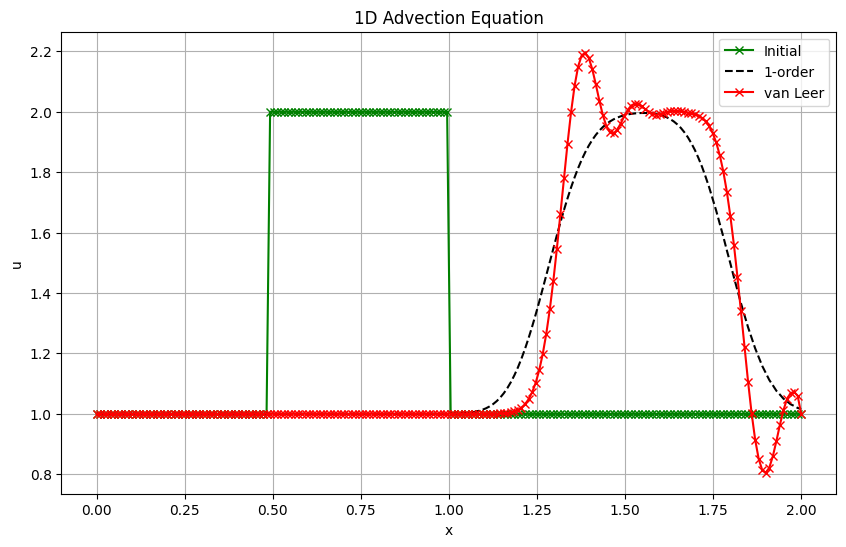

In [54]:
from scipy.integrate import solve_ivp

# Keep original parameters
nx = 200
nt = 20
dx = 2.0 / (nx - 1)
dt = 0.01
c = 4.0
t_span = (0, dt * nt)

x = np.linspace(0, 2, nx)
u_base = np.ones(nx)
u_base[int(0.5 / dx) : int(1 / dx + 1)] = 2

# Keep original methods
u_linear = u_base.copy()
u_second = u_base.copy()


def flux(u):
    return c * u


# Original 1st order method
for n in range(nt):
    un = u_linear.copy()
    for i in range(1, nx):
        u_linear[i] = un[i] - dt / dx * (flux(un[i]) - flux(un[i - 1]))

# Original 2nd order method
for n in range(nt):
    un = u_second.copy()
    for i in range(1 + 1, nx - 1):
        u_i = (un[i] + un[i + 1]) / 2
        u_i_minus = (un[i - 1] + un[i]) / 2
        u_second[i] = un[i] - dt / dx * (flux(u_i) - flux(u_i_minus))


def advection_o1(t, u):
    dudx = np.zeros_like(u)
    for i in range(1, nx):
        dudx[i] = -(flux(u[i]) - flux(u[i - 1])) / dx
    return dudx


def advection_o2(t, u):
    dudx = np.zeros_like(u)
    for i in range(1, nx - 1):
        u_i = (un[i] + un[i + 1]) / 2
        u_i_minus = (un[i - 1] + un[i]) / 2
        dudx[i] = -(flux(u_i) - flux(u_i_minus)) / dx
    return dudx


def van_leer_limiter(r):
    return (r + abs(r)) / (1 + abs(r))


def advection_o3(t, u):
    dudx = np.zeros_like(u)

    for i in range(1, nx - 1):
        delta_minus = u[i] - u[i - 1]
        delta_plus = u[i + 1] - u[i]

        eps = 1e-10

        if abs(delta_minus) > eps:
            r = delta_plus / delta_minus
        else:
            r = delta_plus / eps

        phi = van_leer_limiter(r)
        phi = 1

        u_half = u[i] + 0.5 * phi * delta_minus
        u_half_minus = u[i - 1] + 0.5 * phi * (u[i - 1] - u[i - 2])

        dudx[i] = -(flux(u_half) - flux(u_half_minus)) / dx
    return dudx


sol_o1 = solve_ivp(
    advection_o1, t_span, u_base, method="RK45", t_eval=np.linspace(0, dt * nt, nt + 1), rtol=1e-3, atol=1e-8
)
sol_o2 = solve_ivp(
    advection_o2, t_span, u_base, method="RK45", t_eval=np.linspace(0, dt * nt, nt + 1), rtol=1e-3, atol=1e-8
)
sol_v = solve_ivp(
    advection_o3, t_span, u_base, method="RK45", t_eval=np.linspace(0, dt * nt, nt + 1), rtol=1e-3, atol=1e-8
)

plt.figure(figsize=(10, 6))
plt.plot(x, u_base, "g-x", label="Initial")
plt.plot(x, sol_o1.y[:, -1], "k--", label="1-order")
# plt.plot(x, sol_o2.y[:, -1], "r-x", label="2-order")
plt.plot(x, sol_v.y[:, -1], "r-x", label="van Leer")
plt.grid(True)
plt.xlabel("x")
plt.ylabel("u")
plt.title("1D Advection Equation")
plt.legend()
plt.show()
